# Single-chord Fourier-frame-approx acoustic model example on MAESTRO dataset

In [1]:
import os
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from data.data_utils import play_audio, resample_audio
from data.torch_dataset import SingleChordDataset
from algorithm.multi_pitch_detection_fourier import CisoidDict, remove_amp_vec_noise, remove_amp_vec_noise_peak_finding
from utils import normalize, smooth

from hyperparameters import SOURCE_SAMPLE_RATE, PROJECT_SAMPLE_RATE, PITCH_FREQUENCY_GRID, CISOID_A_TEMPLATE_CKPT_PATH

# set global parameters
TEMPLATE_NOTE_DUR_SEC = 0.5
TEMPLATE_NOTE_GAP_SEC = 1.0

## Step 1: create cisoid dictionary

In [2]:
template_dir = os.path.join("data","synth_chopped")
template_data_name = "all_notes_synth.json"
with open(os.path.join(template_dir,template_data_name), 'r') as fin:
    template_data = json.load(fin)

pitch_num = len(template_data)
raw_templates = [None for _ in range(pitch_num)]
for p in range(pitch_num):
    audio = np.array(template_data[p]["audio"])
    raw_templates[p] = resample_audio(audio, SOURCE_SAMPLE_RATE, PROJECT_SAMPLE_RATE, axis=0)
    raw_templates[p] = normalize(raw_templates[p], std = 1)
    if (p-3) % 24 == 0:
        play_audio(raw_templates[p], PROJECT_SAMPLE_RATE)

transcriptor = CisoidDict(raw_templates, PROJECT_SAMPLE_RATE, frequency_grid = PITCH_FREQUENCY_GRID, smoothify = True, plot = False)
cisoid_dict = transcriptor.cisoid_dict

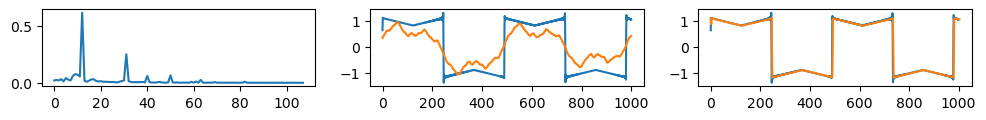

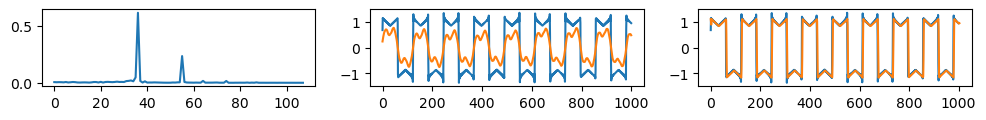

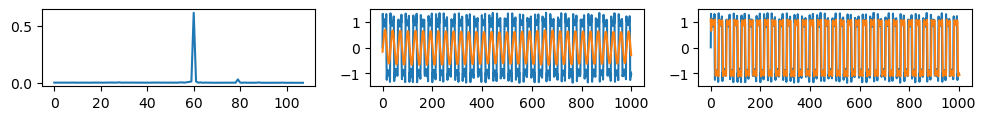

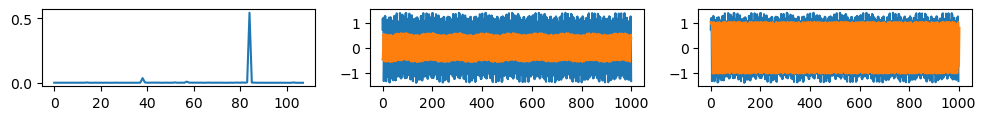

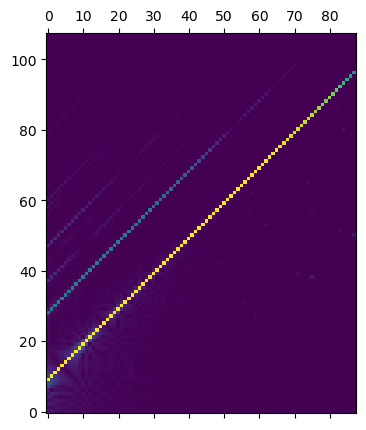

In [3]:
for p in range(pitch_num):
    if (p-3) % 24 == 0:
        fig, ax = plt.subplots(1,3, figsize=(12,1))
        pitches = cisoid_dict[p]
        x_recovered = transcriptor.apply_frame_synthesis_operator(pitches, len(raw_templates[p][:1000]))
        ax[0].plot(abs(pitches))
        ax[1].plot(raw_templates[p][:1000])
        ax[1].plot(np.real(x_recovered))
        ax[2].plot(raw_templates[p][:1000])
        ax[2].plot(smooth(raw_templates[p][:1000], window_len = 5))
        play_audio(np.real(x_recovered), PROJECT_SAMPLE_RATE)

plt.matshow(np.abs(cisoid_dict.T), origin="lower")

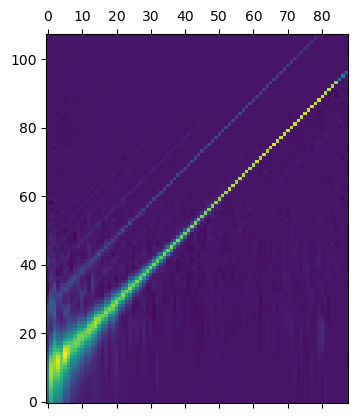

In [4]:
# get trained template matrix
if os.path.exists(CISOID_A_TEMPLATE_CKPT_PATH):
    transcriptor.template_A = np.load(CISOID_A_TEMPLATE_CKPT_PATH)
    transcriptor.prepare_convex_problem()
    fig, ax = plt.subplots(1,1)
    ax.matshow(transcriptor.template_A, origin="lower")

## Step 2: load single chords and do transcription

In [4]:
hdf5s_dir = os.path.join("data", "synth_chopped", "2004_h5")
single_chord_dataset = SingleChordDataset(hdf5s_dir)
print(len(single_chord_dataset))

test_num = 80
test_audios = [None for _ in range(test_num)]
test_durs = [None for _ in range(test_num)]
for i in range(test_num):
    test_audios[i] = np.array(single_chord_dataset[i]["audio"])
    test_audios[i] = normalize(test_audios[i], std = 1)
    test_durs[i] = single_chord_dataset[i]["offset"] - single_chord_dataset[i]["onset"]
    # play_audio(test_audios[i], PROJECT_SAMPLE_RATE)

700000


Transcribing 80 pieces - time consuming:  1.4220035076141357


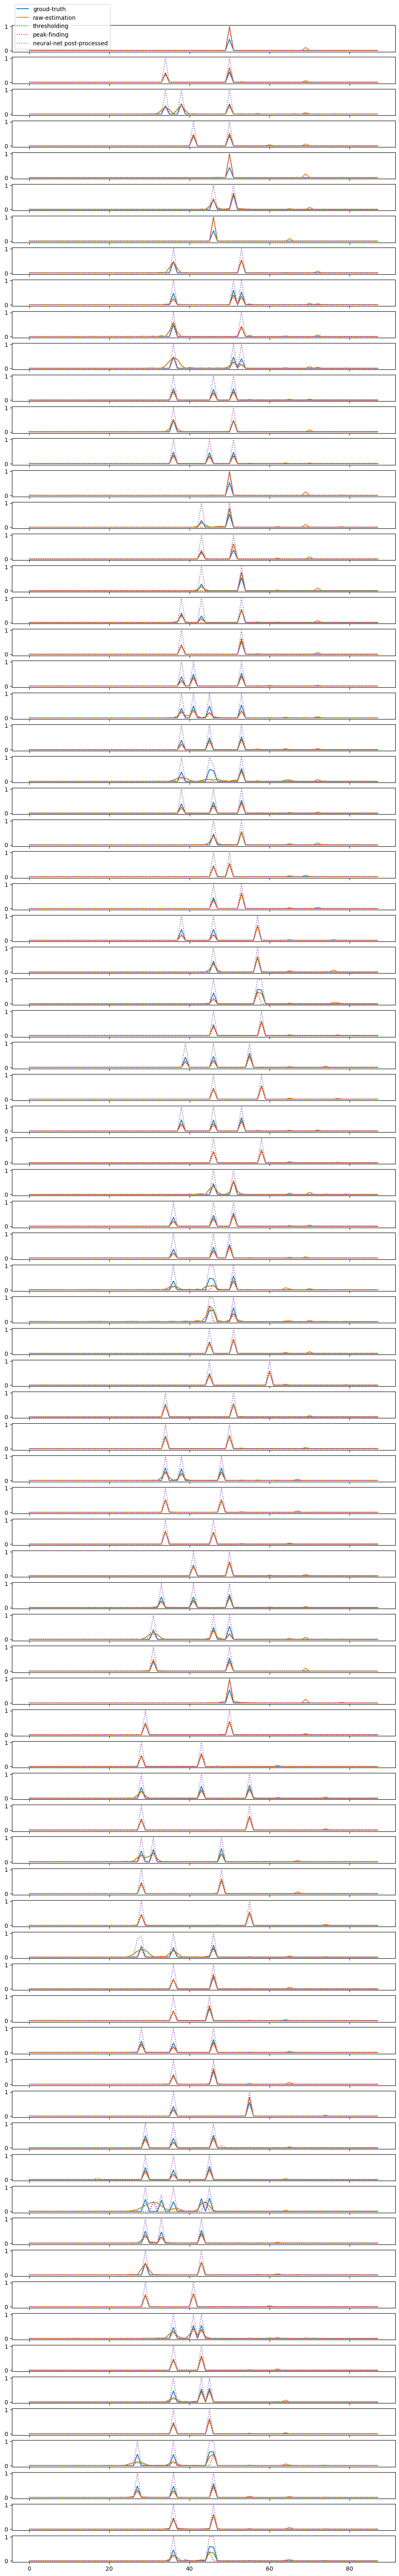

In [5]:
import torch

from model.transduction_net import TransductionFC
from evaluate_main import calculate_single_chord_metric
from utils import normalize, smooth, move_data_to_device
from hyperparameters import TRNASDUCTION_NN_ORI_CKPT_PATH
    

transduction_nn = TransductionFC()
transduction_nn.load_state_dict(torch.load(TRNASDUCTION_NN_ORI_CKPT_PATH))
transduction_nn.eval()


transcription_results = np.zeros((test_num, pitch_num))
transcription_gt = np.zeros((test_num, pitch_num))

# try tune r2

st = time.time()
for i in range(test_num):
    transcription_results[i, :] = transcriptor.single_chord_transcription_powergram(test_audios[i], plot = False)
    # transcription_results[i, :] = transcriptor.transcript_with_sparse_NUV(test_audios[i], N_iter = 3, N_sparsity = 10, r2 = 0.001, init_value = 0.5, plot = False)
    transcription_gt[i, :] = single_chord_dataset[i]["velocity_roll"]
transcription_results = np.abs(transcription_results)
et = time.time()
print("Transcribing", test_num, "pieces - time consuming: ", et-st)

torch_est_rolls = move_data_to_device(np.stack(transcription_results, axis=0), "cpu")
torch_durs = torch.unsqueeze(move_data_to_device(np.stack(test_durs, axis=0), "cpu"), 1)
torch_noisy_velocity_roll_input = torch.cat([torch_est_rolls, torch_durs], dim = 1)
with torch.no_grad():
    est_pitch_prob_rolls = transduction_nn(torch_noisy_velocity_roll_input).numpy()


vel_vectors_after_peak_finding = np.zeros_like(est_pitch_prob_rolls)
for i in range(test_num):
    vel_vectors_after_peak_finding[i] = remove_amp_vec_noise_peak_finding(transcription_results[i, :], min_thres = 0.25)

fig, ax = plt.subplots(test_num,1, figsize=(12,1*test_num), sharex = True, sharey = True)
for i in range(test_num):
    ax[i].plot(transcription_gt[i, :])
    ax[i].plot(transcription_results[i, :])
    ax[i].plot(remove_amp_vec_noise(transcription_results[i, :], rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4), ':')
    ax[i].plot(vel_vectors_after_peak_finding[i], ':')
    ax[i].plot(est_pitch_prob_rolls[i, :], ':')
    
ax[0].legend(["groud-truth", "raw-estimation", "thresholding", "peak-finding", "neural-net post-processed"])


P_peak_finding, R_peak_finding, F_peak_finding = calculate_single_chord_metric((transcription_gt>0)*1, (vel_vectors_after_peak_finding>0.01)*1)
P_nn, R_nn, F1_nn = calculate_single_chord_metric((transcription_gt>0)*1, (est_pitch_prob_rolls>0.1)*1)

In [6]:
print(P_peak_finding, R_peak_finding, F_peak_finding)
print(P_nn, R_nn, F1_nn)

0.9890710382513661 0.923469387755102 0.9551451187335092
0.98 1.0 0.98989898989899


# Calculate the single-chord metrics

In [1]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

from data.torch_dataset import SingleChordDataset
from algorithm.multi_pitch_detection_fourier import get_cisoid_dict, remove_amp_vec_noise, remove_amp_vec_noise_peak_finding
from model.transduction_net import TransductionFC

from evaluate_main import calculate_single_chord_metric
from utils import normalize, smooth, move_data_to_device
from hyperparameters import SOURCE_SAMPLE_RATE, PROJECT_SAMPLE_RATE, PITCH_FREQUENCY_GRID, LOWEST_PITCH
from hyperparameters import TEMPLATE_PATH, TRNASDUCTION_NN_ORI_CKPT_PATH, TRNASDUCTION_NN_TEMPLATE_UPDATED_CKPT_PATH, TRNASDUCTION_NN_NUV_CKPT_PATH
from hyperparameters import CISOID_A_TEMPLATE_CKPT_PATH

# get transcriptor
template_dir = os.path.join("data","synth_chopped")
template_data_name = "all_notes_synth.json"
template_path = os.path.join(template_dir,template_data_name)
transcriptor = get_cisoid_dict(template_path, source_fs = SOURCE_SAMPLE_RATE, tgt_fs = PROJECT_SAMPLE_RATE, frequency_grid = PITCH_FREQUENCY_GRID)
transcriptor_updated = get_cisoid_dict(template_path, source_fs = SOURCE_SAMPLE_RATE, tgt_fs = PROJECT_SAMPLE_RATE, frequency_grid = PITCH_FREQUENCY_GRID)
transcriptor_updated.template_A = np.load(CISOID_A_TEMPLATE_CKPT_PATH)
transcriptor_updated.prepare_convex_problem()

# run transcription
hdf5s_dir = os.path.join("data", "synth_chopped", "2004_h5")
single_chord_dataset = SingleChordDataset(hdf5s_dir)

test_num = int(len(single_chord_dataset) / 100)
np.random.seed(1)
random_ids = np.random.choice(len(single_chord_dataset), size=test_num, replace=False)
est_rolls = [None]*test_num
est_rolls_nuv = [None]*test_num
est_updated_rolls = [None]*test_num
est_updated_rolls_nuv = [None]*test_num
gt_rolls = [None]*test_num
durs = [None]*test_num
for i_test, i_data in enumerate(random_ids):
    test_audio = np.array(single_chord_dataset[i_data]["audio"])
    test_audio = normalize(test_audio, std = 1)
    
    est_rolls[i_test] = transcriptor.single_chord_transcription_powergram(test_audio, plot = False)
    est_rolls_nuv[i_test] = transcriptor.transcript_with_sparse_NUV(test_audio, plot = False)
    est_updated_rolls[i_test] = transcriptor_updated.single_chord_transcription_powergram(test_audio, plot = False)
    est_updated_rolls_nuv[i_test] = transcriptor_updated.transcript_with_sparse_NUV(test_audio, plot = False)
    
    gt_rolls[i_test] = single_chord_dataset[i_data]["velocity_roll"]
    durs[i_test] = len(test_audio) / PROJECT_SAMPLE_RATE

# use thresholding post-processing techniques
est_rolls_thresed = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0) for amp_vec in est_rolls]
est_rolls_thresed_octaves = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4) for amp_vec in est_rolls]
est_rolls_thresed_octaves = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4) for amp_vec in est_rolls]
est_rolls_peak_finding = [remove_amp_vec_noise_peak_finding(amp_vec, min_thres = 0.25) for amp_vec in est_rolls]


est_rolls_nuv_thresed = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0) for amp_vec in est_rolls_nuv]
est_rolls_nuv_thresed_octaves = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4) for amp_vec in est_rolls_nuv]
est_rolls_nuv_peak_finding = [remove_amp_vec_noise_peak_finding(amp_vec, min_thres = 0.25) for amp_vec in est_rolls_nuv]

est_updated_rolls_thresed = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0) for amp_vec in est_updated_rolls]
est_updated_rolls_thresed_octaves = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4) for amp_vec in est_updated_rolls]
est_updated_rolls_peak_finding = [remove_amp_vec_noise_peak_finding(amp_vec, min_thres = 0.25) for amp_vec in est_updated_rolls]


est_updated_rolls_nuv_thresed_octaves = [remove_amp_vec_noise(amp_vec, rel_amp_thres = 0.1, rel_amp_thres_octave = 0.4) for amp_vec in est_updated_rolls_nuv]
est_updated_rolls_nuv_peak_finding = [remove_amp_vec_noise_peak_finding(amp_vec, min_thres = 0.25) for amp_vec in est_updated_rolls_nuv]

# use transduction neural net as post-processing model
transduction_nn = TransductionFC()

transduction_nn.load_state_dict(torch.load(TRNASDUCTION_NN_ORI_CKPT_PATH))
transduction_nn.eval()
torch_est_rolls = move_data_to_device(np.stack(est_rolls, axis=0), "cpu")
torch_durs = torch.unsqueeze(move_data_to_device(np.stack(durs, axis=0), "cpu"), 1)
torch_noisy_velocity_roll_input = torch.cat([torch_est_rolls, torch_durs], dim = 1)
with torch.no_grad():
    est_pitch_prob_rolls = transduction_nn(torch_noisy_velocity_roll_input).numpy()
    est_pitch_prob_rolls[est_pitch_prob_rolls < 0.1] = 0

transduction_nn.load_state_dict(torch.load(TRNASDUCTION_NN_TEMPLATE_UPDATED_CKPT_PATH))
transduction_nn.eval()
torch_est_rolls = move_data_to_device(np.stack(est_updated_rolls, axis=0), "cpu")
torch_durs = torch.unsqueeze(move_data_to_device(np.stack(durs, axis=0), "cpu"), 1)
torch_noisy_velocity_roll_input = torch.cat([torch_est_rolls, torch_durs], dim = 1)
with torch.no_grad():
    est_updated_pitch_prob_rolls = transduction_nn(torch_noisy_velocity_roll_input).numpy()
    est_updated_pitch_prob_rolls[est_updated_pitch_prob_rolls < 0.1] = 0

transduction_nn.load_state_dict(torch.load(TRNASDUCTION_NN_NUV_CKPT_PATH))
transduction_nn.eval()
torch_est_rolls = move_data_to_device(np.stack(est_rolls_nuv, axis=0), "cpu")
torch_durs = torch.unsqueeze(move_data_to_device(np.stack(durs, axis=0), "cpu"), 1)
torch_noisy_velocity_roll_input = torch.cat([torch_est_rolls, torch_durs], dim = 1)
with torch.no_grad():
    est_nuv_pitch_prob_rolls = transduction_nn(torch_noisy_velocity_roll_input).numpy()
    est_nuv_pitch_prob_rolls[est_nuv_pitch_prob_rolls < 0.1] = 0
    


In [4]:
## calculate single-chord metrics

# CO-init
P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls, calculate_var_n_chord = 20)
print(f"MSE approx classical: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_thresed, calculate_var_n_chord = 20)
print(f"MSE approx classical - thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_thresed_octaves, calculate_var_n_chord = 20)
print(f"MSE approx classical - octave thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_peak_finding, calculate_var_n_chord = 20)
print(f"MSE approx classical - peak finding: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_pitch_prob_rolls, calculate_var_n_chord = 20)
print(f"MSE approx classical - NN post_processed: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

# NUV-init
P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_nuv, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_nuv_thresed_octaves, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV - octave thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_rolls_nuv_peak_finding, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV - peak finding: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_nuv_pitch_prob_rolls, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV - NN post_processed: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

# CO-updated
P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls, calculate_var_n_chord = 20)
print(f"MSE approx classical param_updated: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_thresed, calculate_var_n_chord = 20)
print(f"MSE approx classical param_updated - thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_thresed_octaves, calculate_var_n_chord = 20)
print(f"MSE approx classical param_updated - octave thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_peak_finding, calculate_var_n_chord = 20)
print(f"MSE approx classical param_updated - peak finding: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_pitch_prob_rolls, calculate_var_n_chord = 20)
print(f"MSE approx classical param_updated - NN post_processed: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

# NUV-updated
P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_nuv, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV param_updated: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_nuv_thresed_octaves, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV param_updated - octave thresholded: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")

P,R,F1, P_std,R_std,F1_std = calculate_single_chord_metric(gt_rolls, est_updated_rolls_nuv_peak_finding, calculate_var_n_chord = 20)
print(f"MSE approx sparse NUV param_updated - peak finding: P-{P:.4f}±{P_std:.4f}, R-{R:.4f}±{R_std:.4f}, F1-{F1:.4f}±{F1_std:.4f}")


MSE approx classical: P-0.0275±0.0036, R-1.0000±0.0000, F1-0.0536±0.0068
MSE approx classical - thresholded: P-0.3966±0.0663, R-0.9900±0.0153, F1-0.5664±0.0659
MSE approx classical - octave thresholded: P-0.4636±0.0836, R-0.9788±0.0200, F1-0.6292±0.0746
MSE approx classical - peak finding: P-0.9546±0.0372, R-0.8894±0.0561, F1-0.9208±0.0440
MSE approx classical - NN post_processed: P-0.8944±0.0519, R-0.9840±0.0205, F1-0.9371±0.0326
MSE approx sparse NUV: P-0.2366±0.0305, R-0.9773±0.0263, F1-0.3810±0.0396
MSE approx sparse NUV - octave thresholded: P-0.5323±0.0727, R-0.9640±0.0299, F1-0.6859±0.0610
MSE approx sparse NUV - peak finding: P-0.9557±0.0352, R-0.8793±0.0608, F1-0.9160±0.0458
MSE approx sparse NUV - NN post_processed: P-0.8112±0.0814, R-0.9634±0.0339, F1-0.8808±0.0564
MSE approx classical param_updated: P-0.0275±0.0036, R-1.0000±0.0000, F1-0.0536±0.0068
MSE approx classical param_updated - thresholded: P-0.6939±0.0983, R-0.9596±0.0305, F1-0.8054±0.0701
MSE approx classical para

# Pass acoustic model for all pieces getting estimate-gt pairs for transduction model training

In [1]:
import os
import json
import resampy
import numpy as np

from data.data_utils import PieceDataset
from algorithm.multi_pitch_detection_fourier import get_cisoid_dict

from utils import normalize, smooth
from hyperparameters import SOURCE_SAMPLE_RATE, PROJECT_SAMPLE_RATE, PITCH_FREQUENCY_GRID, PITCH_FREQUENCY_GRID_FINER, CISOID_A_TEMPLATE_CKPT_PATH

# get transcriptor
template_dir = os.path.join("data","synth_chopped")
template_data_name = "all_notes_synth.json"
template_path = os.path.join(template_dir,template_data_name)
transcriptor = get_cisoid_dict(template_path, source_fs = SOURCE_SAMPLE_RATE, tgt_fs = PROJECT_SAMPLE_RATE, frequency_grid = PITCH_FREQUENCY_GRID)

# get trained template matrix
USE_UPDATED_MATRIX = False
if os.path.exists(CISOID_A_TEMPLATE_CKPT_PATH) and USE_UPDATED_MATRIX:
    transcriptor.template_A = np.load(CISOID_A_TEMPLATE_CKPT_PATH)
    transcriptor.prepare_convex_problem()

# read pieces
CHOP_WITH_ALGROTIHM = False
midi_dir = os.path.join("data", "midi", "2004")
audio_dir = os.path.join("data", "synth", "2004")
piece_dataset = PieceDataset(midi_dir, audio_dir, 
    pitch_range = 88, lowest_pitch = 21, min_len = 20, 
    transform_velocity = True, audio_extension = ".wav", resample_rate = PROJECT_SAMPLE_RATE, time_as_sec = True,
    chop_with_algorithm = CHOP_WITH_ALGROTIHM # default: False
)

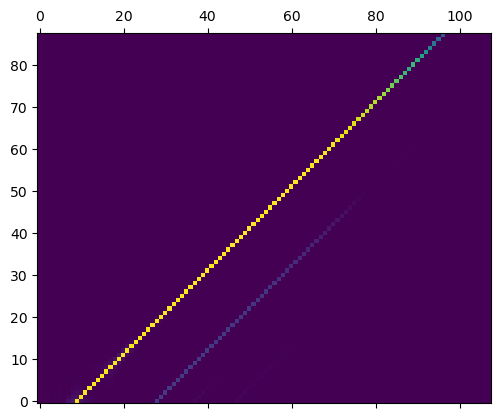

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.matshow(transcriptor.template_A.T, origin="lower")

In [3]:
# result_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_nuv", "2004")
result_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_nuv", "2004")
# result_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_alg_seg", "2004")
# result_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_trained_alg_seg", "2004")

def transcribe_over_piece_dataset(transcriptor, piece_dataset, result_dir):
    for i_piece in range(0, len(piece_dataset)):
        piece_data_dict = piece_dataset[i_piece]
        N_segs = len(piece_data_dict["wav_segs"])
        est_piano_rolls = [None]*N_segs
        print(piece_data_dict["name"], "under transcription...")
        for i_seg in range(N_segs):
            audio_input = piece_data_dict["wav_segs"][i_seg]
            # est_piano_rolls[i_seg] = np.abs(transcriptor.single_chord_transcription_powergram(audio_input, plot = False))
            est_piano_rolls[i_seg] = np.abs(transcriptor.transcript_with_sparse_NUV(audio_input, N_iter = 3, N_sparsity = 10, r2 = 0.001, init_value = 0.5, plot = False))
            if i_seg % 2000 == 0 and i_seg > 0:
                print("The number ", i_seg, " segment has been transcribed!")

        transcribed_data_dict = {
            "gt_velocity_rolls": [piece_data_dict["velocity_rolls"][i].tolist() for i in range(N_segs)],
            "est_velocity_rolls": [est_piano_rolls[i].tolist() for i in range(N_segs)],
            "onsets": piece_data_dict["onsets"],
            "offsets": piece_data_dict["offsets"],
        }
        with open(os.path.join(result_dir, piece_data_dict["name"]+".json"), 'w') as fout:
            json.dump(transcribed_data_dict, fout)
        print(piece_data_dict["name"], "finished!")

In [4]:
transcribe_over_piece_dataset(transcriptor, piece_dataset, result_dir)

MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav under transcription...
The number  2000  segment has been transcribed!
The number  4000  segment has been transcribed!
The number  6000  segment has been transcribed!
The number  8000  segment has been transcribed!
The number  10000  segment has been transcribed!
The number  12000  segment has been transcribed!
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav finished!
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav under transcription...
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav finished!
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav under transcription...
The number  2000  segment has been transcribed!
The number  4000  segment has been transcribed!
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav finished!
MIDI-Unprocessed_SMF_02_R1_2004_01-